In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
tf.config.list_physical_devices('GPU')


[]

In [3]:
image_size = (180, 180)
batch_size = 3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "halves",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 26 files belonging to 13 classes.
Using 21 files for training.


In [4]:
num_classes = len(train_ds.class_names)

In [9]:
label_dict = {
    0:0,
    1:10,
    2:11,
    3:12,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5,
    9:6,
    10:7,
    11:8,
    12:9,
}

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    # print(labels)

    for i in range(9):
        label_num = np.argmax(labels[i].numpy())
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_num)
        plt.axis("off")

InvalidArgumentError: slice index 3 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomContrast(factor=0.4),
        # layers.experimental.preprocessing.RandomCrop(),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.3, width_factor=0.3),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.3, width_factor=0.3),
    ]
)


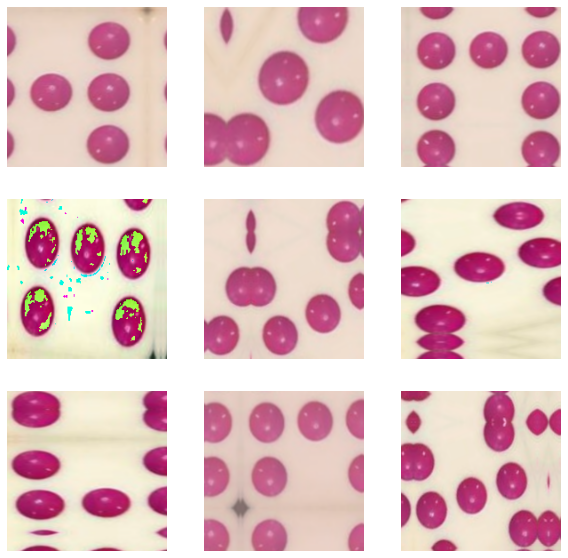

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [13]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)

In [42]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # for size in [128, 256, 512, 728]:
    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    # if num_classes == 2:
    #     activation = "sigmoid"
    #     units = 1
    # else:
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)


In [43]:
image_size

(180, 180)

In [44]:
 tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [45]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("model/save_at_{epoch}.h5"),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    # loss="categorical_crossentropy",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, 
    # validation_data=val_ds,
)


Epoch 1/100
7/7 [==============================] - 3s 297ms/step - loss: 2.5516 - accuracy: 0.1140
Epoch 2/100
7/7 [==============================] - 2s 270ms/step - loss: 2.0291 - accuracy: 0.3275
Epoch 3/100
7/7 [==============================] - 2s 267ms/step - loss: 1.7034 - accuracy: 0.4141
Epoch 4/100
7/7 [==============================] - 2s 269ms/step - loss: 1.7275 - accuracy: 0.3862
Epoch 5/100
7/7 [==============================] - 2s 270ms/step - loss: 1.5623 - accuracy: 0.3987
Epoch 6/100
7/7 [==============================] - 2s 267ms/step - loss: 1.6259 - accuracy: 0.4447
Epoch 7/100
7/7 [==============================] - 2s 266ms/step - loss: 1.8735 - accuracy: 0.3571
Epoch 8/100
7/7 [==============================] - 2s 280ms/step - loss: 1.6920 - accuracy: 0.4387
Epoch 9/100
7/7 [==============================] - 2s 273ms/step - loss: 1.7078 - accuracy: 0.5388
Epoch 10/100
7/7 [==============================] - 2s 269ms/step - loss: 1.1762 - accuracy: 0.6499
Epoch 11/

In [46]:
# list(os.walk("halves/"))
import glob
import random

image_files = glob.glob("halves/*/*.jpg")
image_to_predict = image_files[random.randint(0, len(image_files)-1)]

halves\8_eight\8.jpg
Preds: [0.20012909 0.01517079 0.04823377 0.11388672 0.10323551 0.07588818
 0.13078414 0.10439428 0.07803212 0.05973446 0.03386733 0.02086748
 0.0157761 ]
0
0


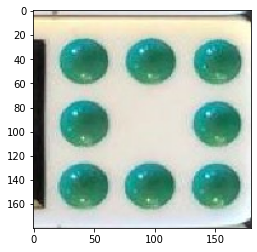

In [48]:
image_to_predict = image_files[random.randint(0, len(image_files)-1)]
print(image_to_predict)

img = keras.preprocessing.image.load_img(
    # "halves/9_nine/9-2.jpg", target_size=image_size
    # "halves/1_one/1-2.jpg", target_size=image_size
    # "halves/6_six/6.jpg", target_size=image_size
    image_to_predict, target_size=image_size
)

plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(f"Preds: {predictions[0]}")
print(np.argmax(predictions[0]))
print(label_dict[np.argmax(predictions[0])])

In [22]:
label_dict

{0: 0,
 1: 10,
 2: 11,
 3: 12,
 4: 1,
 5: 2,
 6: 3,
 7: 4,
 8: 5,
 9: 6,
 10: 7,
 11: 8,
 12: 9}